# Imports

Installs

In [ ]:
!pip install import-ipynb -qqq

Imports

In [ ]:
import torch
import numpy as np
import import_ipynb
import torch.nn as nn

from random import shuffle
from google.colab import drive

from pickle import dump, load

from torch.utils.data import DataLoader
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier

from data_prep import MH_TrainValGenerator

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Setting Project directory as current directory

In [ ]:
%cd drive/Shareddrives/CIS 4190 5190/Project/

/content/drive/Shareddrives/CIS 4190 5190/Project


Importing ipynb functions

In [ ]:
from dataLoading import *
from Copymodel import modelV1, ConvNet1D, RNNModel

importing Jupyter notebook from dataLoading.ipynb
importing Jupyter notebook from Copymodel.ipynb


# Config

In [ ]:
class Config():
  def __init__(self, sample_length, test_prop, batch_size, epochs, lr, device):
    self.sample_length = sample_length
    self.test_prop = test_prop
    self.batch_size = batch_size
    self.epochs = epochs
    self.lr = lr
    self.device = device

In [ ]:
c = Config(16, 0.7, 32, 2, 3e-4, "cuda")

# Dataframes

In [ ]:
project_path = "drive/Shareddrives/CIS 4190 5190/Project/"

mhealth_files = getMHEALTHFiles()

val_sets = getSets(mhealth_files)

# Creating contiguous sensor samples of length Config.sample_length

In [ ]:
#@title (start, end) of contiguous periods of sensor information
def getContiguousStartInds(mhealth_df):
  cont_start_inds = dict()
  for label in mhealth_df.Label.unique():
    activity = mhealth_df[mhealth_df["Label"] == label].sort_index()

    inds = activity.index.unique().tolist()

    cont = [inds[i] == inds[i-1] + 1 for i in range(1, len(inds))]

    start_inds = [inds[0]]
    end_inds = []
    for i in range(len(cont)):
      if not cont[i]:
        start_inds.append(inds[i+1])
        end_inds.append(inds[i])
    end_inds.append(inds[-1])

    cont_start_inds[label] = list(zip(start_inds, end_inds))
  return cont_start_inds

In [ ]:
#@title function to process data given df
def processData(mhealth_df):
  # dict with {activity_label: [sensor_start_0, sensor_start_1, ...]}
  cont_sensor_slices = getContiguousStartInds(mhealth_df)


  #@title Creating contiguous samples of length n, {label: [(start_0, end_0), (start_1, end_1)]}
  sample_slices = dict()

  for label in mhealth_df.Label.unique():
    sample_slices[label] = []
    slices = cont_sensor_slices[label]
    for data_slice in slices:
      start, end = data_slice
      for s in range(start, end - c.sample_length): # length of samples from config
        e = s + c.sample_length
        sample_slices[label].append((s, e))
  

  #@title Balancing dataset wrt classes
  min_num_samps = float("inf")
  labels = list(mhealth_df.Label.unique())
  labels.remove(0)
  for label in labels:
    min_num_samps = min(len(sample_slices[label]), min_num_samps)

  balanced_omega_slices = []
  for label in labels:
    shuffle(sample_slices[label])
    balanced_omega_slices += sample_slices[label][:min_num_samps]


  #@title Converting samples to numpy array (omega)
  omega = []
  for (s, e) in balanced_omega_slices:
    sample = np.expand_dims(mhealth_df.iloc[s:e].to_numpy(), 0)
    omega.append(sample)
  shuffle(omega)
  omega = np.vstack(omega)


  return omega

# Random Forest Baseline

In [ ]:
# shuffle data
data = mhealth_df.to_numpy()
np.random.shuffle(data)

# reduce dataset size
data = data[:30000]

# train and test splits
X = data[:, :-1]
y = data[:, -1]
split_ind = round(data.shape[0] * 0.7)
train_X, train_y = X[:split_ind], y[:split_ind]
test_X, test_y = X[split_ind:], y[split_ind:]

NameError: ignored

In [ ]:
# fit random forest
rf = RandomForestClassifier()
rf.fit(train_X, train_y)

In [ ]:
# classification accuracy
sum(rf.predict(test_X) == test_y) / test_y.shape[0]

# KMeans

In [ ]:
# shuffle data
non_null_mhealth = mhealth_df[mhealth_df["Label"] != 0]
data = non_null_mhealth.to_numpy()
np.random.shuffle(data)

from sklearn.preprocessing import StandardScaler
ss = StandardScaler().fit(data)
data = ss.transform(data)

# reduce dataset size
data = data[:300000]

# train and test splits
X = data[:, :-1]
y = data[:, -1]
split_ind = round(data.shape[0] * 0.7)
train_X, train_y = X[:split_ind], y[:split_ind]
test_X, test_y = X[split_ind:], y[split_ind:]

NameError: ignored

In [ ]:
data.mean(axis=0).shape

In [ ]:
kmeans = KMeans(n_clusters=12).fit(train_X, train_y)
preds = kmeans.predict(test_X)

In [ ]:
sum(preds == test_y) / len(test_y)

# Training and Testing Functions

In [ ]:
def train(model, optimizer, loss_fn, trainloader, c):
  model.train()
  for epoch in range(c.epochs):
    for i, batch in enumerate(trainloader):
      batch.requires_grad_(True)
      x, y = batch[:, :, :-1].float(), batch[:, :, -1]
      x, y = x.to(c.device), y.to(c.device)[:, 0].long()

      optimizer.zero_grad()

      preds = model(x)
      loss = loss_fn(preds, y)

      loss.backward()
      optimizer.step()

      if i % 500 == 0:
        print(f"epoch: {epoch}, batch: {i}, loss: {loss.item()}")
        print(f"accuracy: {sum(preds.argmax(axis=1) == y).item() / preds.shape[0]}")
        print()

# 10-Fold Cross Validation

create pickled folds!

In [ ]:
#@title runs out of RAM if using c.sample_length = 32
folds_folder = "Pickled Folds/"
if f"PICKLED_FOLDS_{c.sample_length}" not in listdir(folds_folder):
  folds = []
  for train_list, val in val_sets:
    trainset = processData(combineFiles(train_list))
    valset = processData(combineFiles([val]))

    folds.append({"trainset": trainset,
                  "valset": valset})

  with open(f"{folds_folder}PICKLED_FOLDS_{c.sample_length}", "wb+") as f:
    dump(folds, f)

load pickled folds

In [ ]:
with open(f"{folds_folder}PICKLED_FOLDS_{c.sample_length}", "rb") as f:
  folds = load(f)

start training

In [ ]:
mh_trainval = MH_TrainValGenerator(c)

In [ ]:
val_loaders = []
trained_models = []
# for train_list, val in val_sets:
#   trainset = processData(combineFiles(train_list))
#   valset = processData(combineFiles([val]))

for i in range(len(mh_trainval)):
# for i in range(len(folds)):
  # trainset = folds[i]["trainset"]
  # valset = folds[i]["valset"]
  trainset, valset = mh_trainval[i]

  trainloader, valloader = DataLoader(trainset, c.batch_size, shuffle=True), DataLoader(valset, c.batch_size, shuffle=True)
  val_loaders.append(valloader)

  # model = modelV1(c).to(c.device)
  #model = ConvNet1D(c).to(c.device)
  model = RNNModel(23, 13, 13, 1).to(c.device)
  
  optimizer = torch.optim.Adam(model.parameters(), c.lr)
  loss_fn = nn.CrossEntropyLoss()

  train(model, optimizer, loss_fn, trainloader, c)
  trained_models.append(model)

RuntimeError: ignored

In [ ]:
accs = []
activity_corrs = []
activity_tots = []

for i, val_loader in enumerate(val_loaders):
  mod = trained_models[i]

  t = iter(val_loader)

  activity_corr = dict()
  activity_total = dict()
  corr, total = 0, 0
  for b in val_loader:
    x, y = b[:, :, :-1].float(), b[:, :, -1]
    x, y = x.to(c.device), y.to(c.device)[:, 0]

    preds = model(x).argmax(axis=1)

    corr += sum(preds == y)
    for i in range(len(x)):
      p, t = preds[i].item(), y[i].item()
      if p == t:
        if p in activity_corr: 
          activity_corr[p] += 1 
        else:
          activity_corr[p] = 1
      if p in activity_total:
        activity_total[p] += 1
      else:
        activity_total[p] = 1
      
    total += y.shape[0]

  accs.append((corr / total).item())
  activity_corrs.append(activity_corr)
  activity_tots.append(activity_total)

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:139: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


In [ ]:
sum(accs) / len(accs)

0.9218408048152924

In [ ]:
omega = trainset.squeeze()
omega.shape

(110988, 24)

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

logreg = LogisticRegression("l2")
dettr = DecisionTreeClassifier()


te, va = trainset.squeeze(), valset.squeeze()
tr_x, tr_y = te[:, :-1], te[:, -1]
va_x, va_y = va[:, :-1], va[:, -1]


# logreg.fit(tr_x, tr_y)
dettr.fit(tr_x, tr_y)

DecisionTreeClassifier()

In [ ]:
# preds = logreg.predict(va_x)
preds = dettr.predict(va_x)


sum(preds == va_y) / len(preds)

0.7817645231438335

In [ ]:
import matplotlib.pyplot as plt
from sklearn import tree

KeyboardInterrupt: ignored

Error in callback <function install_repl_displayhook.<locals>.post_execute at 0x7ff831744d40> (for post_execute):


KeyboardInterrupt: ignored

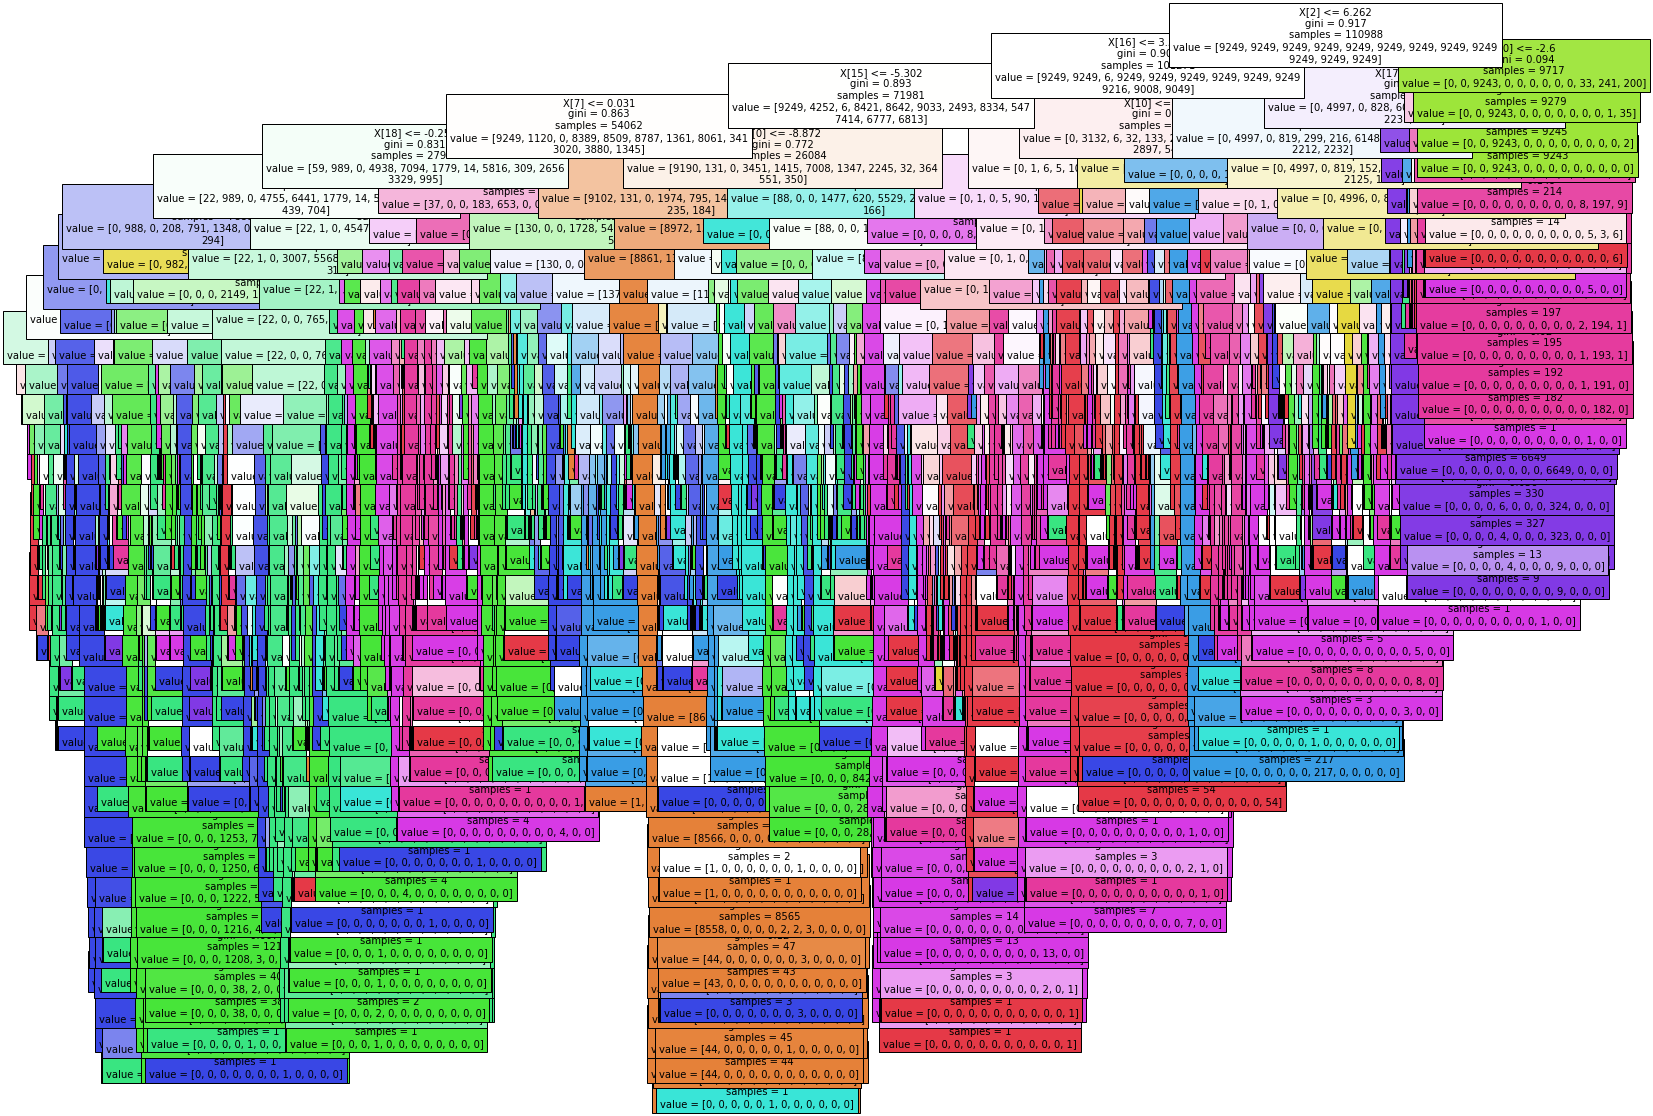

In [ ]:
fig = plt.figure(figsize=(25,20))
_ = tree.plot_tree(dettr, 
                   filled=True)
